In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Project I | Deep Learning: Image Classification with CNN

##Datasets

We will work with the Animals-10 dataset (https://www.kaggle.com/datasets/alessiocorrado99/animals10/code)

In [ ]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from tensorflow.keras.metrics import F1Score, Precision, Recall

from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from sklearn.utils import class_weight

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np

#1. Data Preprocessing

In [ ]:

# Define your source and destination directories
nico_dir = '/content/drive/MyDrive/Ironhack/week3/Animals-10/raw-img'
output_dir = '/content/presplit_data'

# Define the split ratios
train_split = 0.8  # 80% for training
val_split = 0.2    # 20% for validation

# Create the new directory structure if it doesn't exist
os.makedirs(os.path.join(output_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'validation'), exist_ok=True)

# Get a list of all class folders (your labels)
class_folders = [f for f in os.listdir(nico_dir) if os.path.isdir(os.path.join(nico_dir, f))]

# Iterate through each class folder
for class_name in class_folders:
    # Create class subdirectories in train and validation folders
    os.makedirs(os.path.join(output_dir, 'train', class_name), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'validation', class_name), exist_ok=True)

    # Get all the image files for the current class
    class_path = os.path.join(nico_dir, class_name)
    images = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    # Shuffle the list of images to ensure a random split
    random.shuffle(images)

    # Calculate the number of images for training and validation
    train_count = int(len(images) * train_split)

    # Split the images
    train_images = images[:train_count]
    val_images = images[train_count:]

    # Copy files to the new directories
    print(f"Splitting class: {class_name}")
    for img_path in train_images:
        shutil.copy(img_path, os.path.join(output_dir, 'train', class_name, os.path.basename(img_path)))

    for img_path in val_images:
        shutil.copy(img_path, os.path.join(output_dir, 'validation', class_name, os.path.basename(img_path)))

print("Data splitting complete!")

Splitting class: pecora
Splitting class: ragno
Splitting class: gatto
Splitting class: elefante
Splitting class: gallina
Splitting class: farfalla
Splitting class: cavallo
Splitting class: mucca
Splitting class: cane
Splitting class: scoiattolo
Data splitting complete!


In [ ]:
train_dir = '/content/presplit_data/train'
val_dir = '/content/presplit_data/validation'

In [ ]:
# Mapping from Italian to English
translate = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "scoiattolo": "squirrel",
    "ragno" : "spider"
}

# List of directories to process
directories_to_process = [train_dir, val_dir]

for current_base_dir in directories_to_process:
    print(f"--- Processing directory: {current_base_dir} ---")

    # Iterate through all items in the current directory
    for folder_name in os.listdir(current_base_dir):
        # Check if the item is a directory
        current_path = os.path.join(current_base_dir, folder_name)
        if os.path.isdir(current_path):
            # Check if the folder name is in our translation dictionary
            if folder_name in translate:
                new_folder_name = translate[folder_name]
                new_path = os.path.join(current_base_dir, new_folder_name)

                # Rename the folder
                os.rename(current_path, new_path)
                print(f"Renamed '{folder_name}' to '{new_folder_name}'")
            else:
                print(f"Skipping folder '{folder_name}' as no translation was found.")

    print(f"--- Finished processing {current_base_dir} ---")

print("\nAll specified folders have been renamed.")

--- Processing directory: /content/presplit_data/train ---
Renamed 'gallina' to 'chicken'
Renamed 'pecora' to 'sheep'
Renamed 'cavallo' to 'horse'
Renamed 'cane' to 'dog'
Renamed 'gatto' to 'cat'
Renamed 'scoiattolo' to 'squirrel'
Renamed 'ragno' to 'spider'
Renamed 'elefante' to 'elephant'
Renamed 'farfalla' to 'butterfly'
Renamed 'mucca' to 'cow'
--- Finished processing /content/presplit_data/train ---
--- Processing directory: /content/presplit_data/validation ---
Renamed 'gallina' to 'chicken'
Renamed 'pecora' to 'sheep'
Renamed 'cavallo' to 'horse'
Renamed 'cane' to 'dog'
Renamed 'gatto' to 'cat'
Renamed 'scoiattolo' to 'squirrel'
Renamed 'ragno' to 'spider'
Renamed 'elefante' to 'elephant'
Renamed 'farfalla' to 'butterfly'
Renamed 'mucca' to 'cow'
--- Finished processing /content/presplit_data/validation ---

All specified folders have been renamed.


In [ ]:
IMG_SIZE = (64,64)
batch_size = 64

# Normalize and augment data
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.1,
    horizontal_flip = True, # this helps the model learn the animals and not rotations of the image or other unwanted features
    vertical_flip = False, # animals usually don't stand on their heads
)

# Load train and validation data
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,
    target_size = IMG_SIZE,  # Resize to consistent size
    batch_size = batch_size,
    class_mode = 'categorical',
)

val_datagen = ImageDataGenerator(
    rescale = 1./255,
)

val_generator = val_datagen.flow_from_directory(
    directory = val_dir,
    target_size = IMG_SIZE,
    batch_size = batch_size,
    class_mode = 'categorical',
)


Found 20938 images belonging to 10 classes.
Found 5241 images belonging to 10 classes.


In [ ]:
val_generator.class_indices

{'butterfly': 0,
 'cat': 1,
 'chicken': 2,
 'cow': 3,
 'dog': 4,
 'elephant': 5,
 'horse': 6,
 'sheep': 7,
 'spider': 8,
 'squirrel': 9}

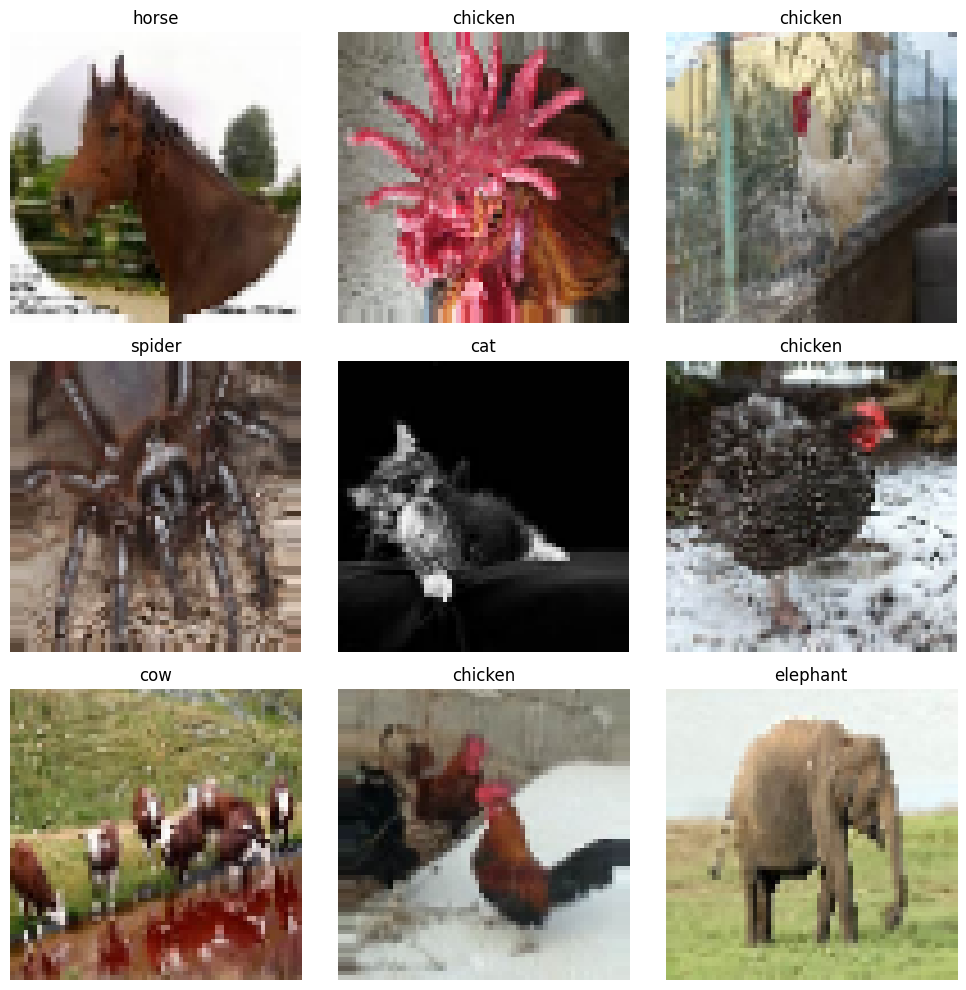

In [ ]:
images, labels = next(train_generator)
class_names = list(val_generator.class_indices.keys())

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])
    label_name = class_names[label_index]
    plt.title(label_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

#2. Model Architecture

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D((2, 2)),

    #layers.Conv2D(128, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation = 'relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation = 'softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#3. Model Training

In [ ]:
#model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

early_stop = EarlyStopping(monitor = 'val_loss', patience=2, restore_best_weights=True)

epochs = 10

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs = epochs,
    callbacks = [early_stop]
)
current_directory = os.getcwd()
model.save('model_1.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 68s 190ms/step - accuracy: 0.2258 - loss: 2.1461 - val_accuracy: 0.3864 - val_loss: 1.7550
Epoch 2/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 55s 167ms/step - accuracy: 0.3725 - loss: 1.7800 - val_accuracy: 0.4816 - val_loss: 1.5737
Epoch 3/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 50s 152ms/step - accuracy: 0.4222 - loss: 1.6598 - val_accuracy: 0.4741 - val_loss: 1.5772
Epoch 4/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 49s 150ms/step - accuracy: 0.4555 - loss: 1.5668 - val_accuracy: 0.5098 - val_loss: 1.4377
Epoch 5/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 51s 156ms/step - accuracy: 0.4743 - loss: 1.5143 - val_accuracy: 0.5127 - val_loss: 1.4729
Epoch 6/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 53s 162ms/step - accuracy: 0.4791 - loss: 1.4729 - val_accuracy: 0.5123 - val_loss: 1.4539


#4. Model Evaluation

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,468,768 (9.42 MB)

 Trainable params: 822,922 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,645,846 (6.28 MB)

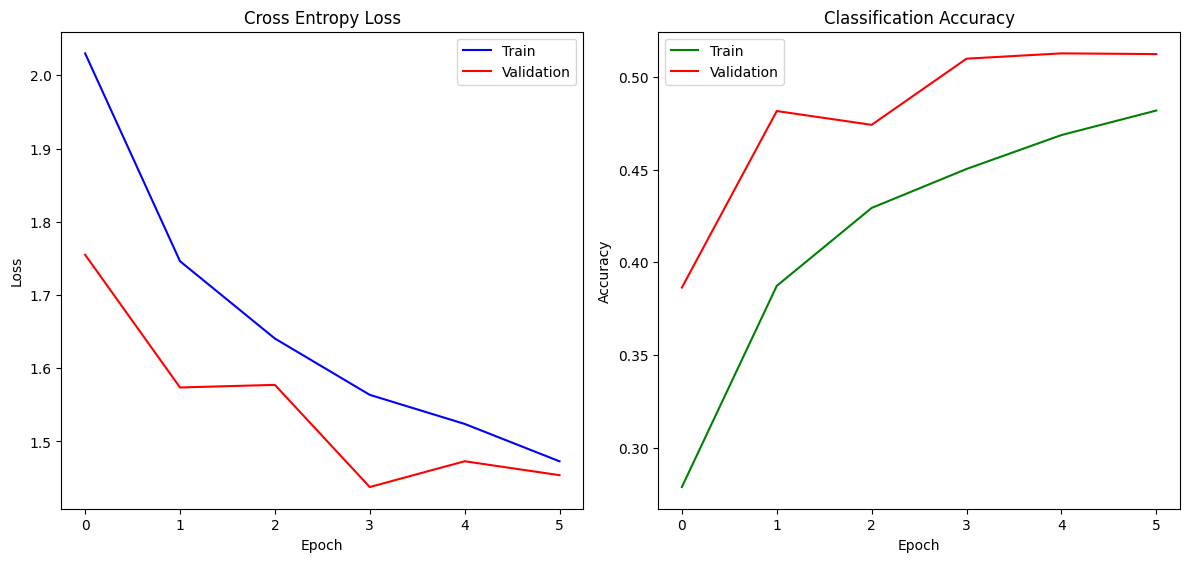

In [ ]:

model.summary()

# Increase figure size
plt.figure(figsize=(12, 16))

# 1. Cross Entropy Loss
plt.subplot(3, 2, 1)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color = 'blue', label = 'Train')
plt.plot(history.history['val_loss'], color = 'red', label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 2. Accuracy
plt.subplot(3, 2, 2)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='green', label='Train')
plt.plot(history.history['val_accuracy'], color='red', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


## model is performing poorly, we will apply some adjustments.
1. compile, track more metrics
2. add another layer, 128 (3,3)
3. increase early stopping patience 2 -> 4
4. increase epochs 10 -> 20

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'), # Added another layer to improve model
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

epochs = 20

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stop]
)
current_directory = os.getcwd()
model.save('model_2.keras')

Epoch 1/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 58s 164ms/step - accuracy: 0.2263 - loss: 2.1539 - val_accuracy: 0.3583 - val_loss: 1.8251
Epoch 2/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 53s 160ms/step - accuracy: 0.3582 - loss: 1.8449 - val_accuracy: 0.4505 - val_loss: 1.5893
Epoch 3/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 52s 158ms/step - accuracy: 0.4166 - loss: 1.6740 - val_accuracy: 0.5070 - val_loss: 1.4311
Epoch 4/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 51s 157ms/step - accuracy: 0.4597 - loss: 1.5486 - val_accuracy: 0.5663 - val_loss: 1.3370
Epoch 5/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 53s 160ms/step - accuracy: 0.4915 - loss: 1.4662 - val_accuracy: 0.5426 - val_loss: 1.3857
Epoch 6/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 51s 156ms/step - accuracy: 0.5109 - loss: 1.4129 - val_accuracy: 0.5608 - val_loss: 1.3255
Epoch 7/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 55s 166ms/step - accuracy: 0.5287 - loss: 1.3507 - val_accuracy: 0.5821 - val_loss: 1.2670
Epoch 8/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 50s 153ms/step - accuracy: 0.5490 - loss: 1


--- Model Evaluation after Fine-tuning ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━

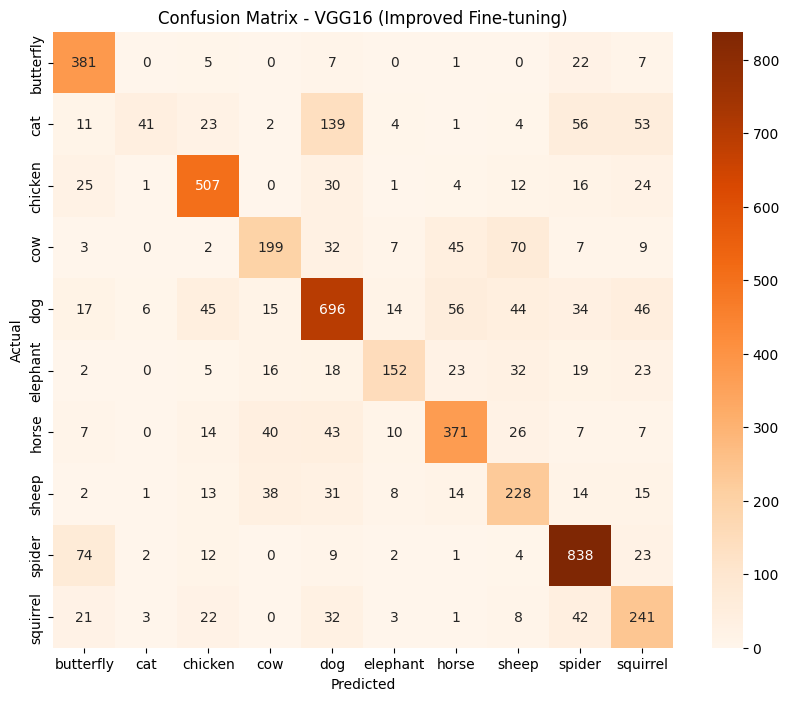

NameError: name 'history' is not defined

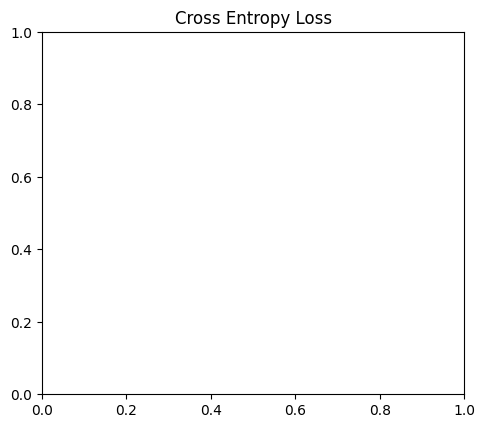

In [ ]:
model = load_model("/content/drive/MyDrive/Ironhack/week3/Animal Image Classification Project/model_2.keras")
# --- Evaluation and Visualization ---
print("\n--- Model Evaluation after Fine-tuning ---")

# Get ground truth labels
y_true = []
y_pred = []

for i in range(len(val_generator)):
    x_batch, y_batch = val_generator[i]
    preds = model.predict(x_batch)

    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Compute metrics
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(y_true, y_pred, target_names=class_names))

cm_vgg = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_vgg, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Oranges")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - VGG16 (Improved Fine-tuning)")
plt.show()

# --- Plotting Training History ---
# Increase figure size
plt.figure(figsize=(12, 16))

# 1. Cross Entropy Loss
plt.subplot(3, 2, 1)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='Train')
plt.plot(history.history['val_loss'], color='red', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 2. Accuracy
plt.subplot(3, 2, 2)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='green', label='Train')
plt.plot(history.history['val_accuracy'], color='red', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
loss, accuracy = model.evaluate(val_generator, verbose=1)

print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 0.6970 - loss: 0.8956
Validation Loss: 0.9091
Validation Accuracy: 0.6972


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,166,624 (4.45 MB)

 Trainable params: 388,874 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 777,750 (2.97 MB)

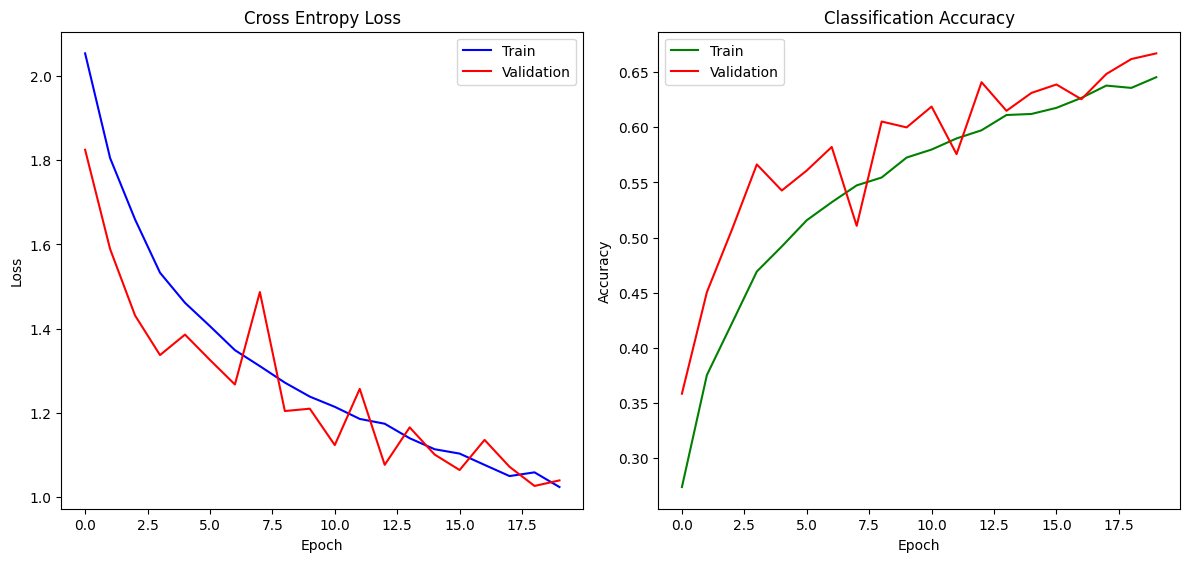

Changes for the third model:
1. Added second convolutional layer
2. Added droput 0.25 after every layer
3. Increased Dense layer to 512
4. early_stop mintor changed to val_loss
5. +30 epochs
6. Vertical_flip = False - learning upside down animals doesn't really represent real world
7. Reduced batch_size to 64 (from 128) for all models
8. zoom_range = 0.1 for all models

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    Conv2D(32, (3, 3), activation='relu'), # Added another layer to improve model
    Dropout(0.25), # dont learn the wrong stuff
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'), # Added another layer to improve model
    Dropout(0.25), # dont learn the wrong stuff
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'), # Added another layer to improve model
    Dropout(0.25), # dont learn the wrong stuff
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'), # big increase here
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

epochs = 50 # +30

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stop]
)
current_directory = os.getcwd()
model.save('model_3.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 70s 185ms/step - accuracy: 0.2131 - loss: 2.1746 - val_accuracy: 0.3368 - val_loss: 1.9246
Epoch 2/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 55s 167ms/step - accuracy: 0.3622 - loss: 1.8468 - val_accuracy: 0.4091 - val_loss: 1.7539
Epoch 3/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 58s 177ms/step - accuracy: 0.4493 - loss: 1.5995 - val_accuracy: 0.4310 - val_loss: 1.6447
Epoch 4/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 53s 162ms/step - accuracy: 0.5076 - loss: 1.4517 - val_accuracy: 0.5421 - val_loss: 1.4022
Epoch 5/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 53s 162ms/step - accuracy: 0.5703 - loss: 1.2634 - val_accuracy: 0.4778 - val_loss: 1.5611
Epoch 6/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 84s 168ms/step - accuracy: 0.5844 - loss: 1.2197 - val_accuracy: 0.5510 - val_loss: 1.3249
Epoch 7/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 57s 175ms/step - accuracy: 0.6195 - loss: 1.1216 - val_accuracy: 0.5650 - val_loss: 1.3051
Epoch 8/50
328/328 ━━━━━━━━━━━━━━━━━━━━ 64s 195ms/step - accuracy: 0.6387 - loss: 1


--- Model Evaluation after Fine-tuning ---
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
2/2 ━━━━━━━━━━━━━━━━

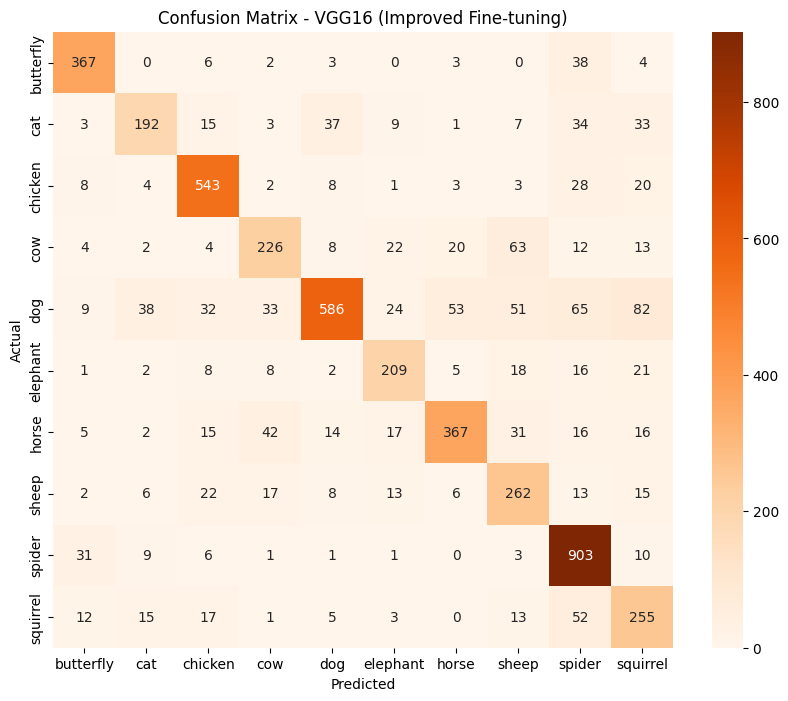

In [ ]:
model = load_model("/content/drive/MyDrive/Ironhack/week3/Animal Image Classification Project/model_3.keras")
# --- Evaluation and Visualization ---
print("\n--- Model Evaluation after Fine-tuning ---")

# Get ground truth labels
y_true = []
y_pred = []

for i in range(len(val_generator)):
    x_batch, y_batch = val_generator[i]
    preds = model.predict(x_batch)

    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Compute metrics
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(y_true, y_pred, target_names=class_names))

cm_vgg = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_vgg, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Oranges")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - VGG16 (Improved Fine-tuning)")
plt.show()



In [ ]:
# --- Plotting Training History ---
# Increase figure size
plt.figure(figsize=(12, 16))

# 1. Cross Entropy Loss
plt.subplot(3, 2, 1)
plt.title('Cross Entropy Loss')
plt.plot(history_improved.history['loss'], color='blue', label='Train')
plt.plot(history_improved.history['val_loss'], color='red', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 2. Accuracy
plt.subplot(3, 2, 2)
plt.title('Classification Accuracy')
plt.plot(history_improved.history['accuracy'], color='green', label='Train')
plt.plot(history_improved.history['val_accuracy'], color='red', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 26, 26, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 9, 9, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,023,680 (15.35 MB)

 Trainable params: 1,341,226 (5.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,682,454 (10.23 MB)

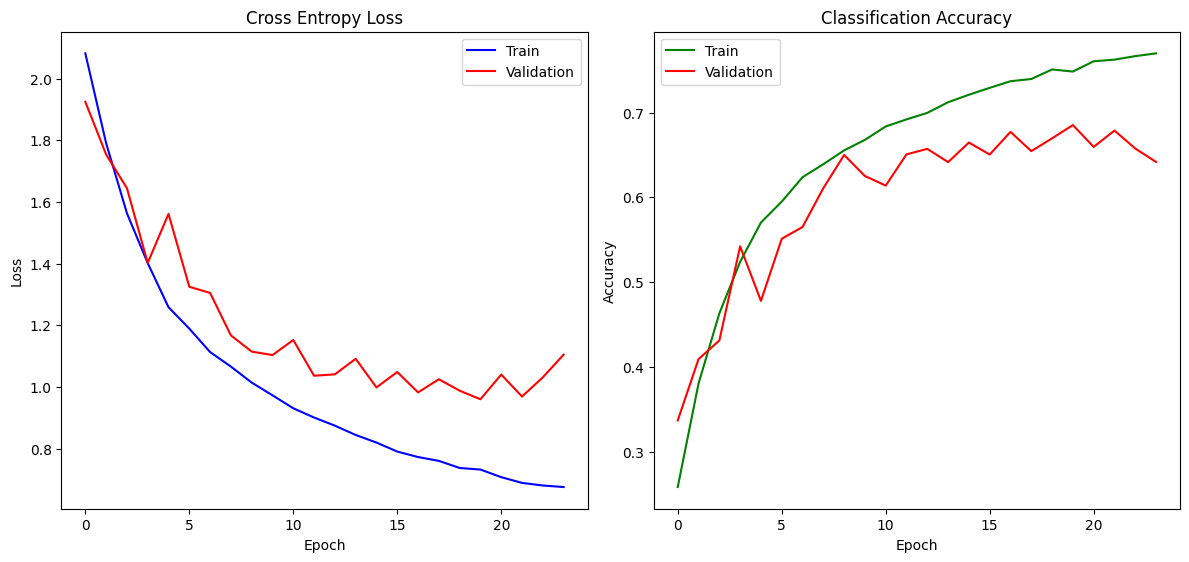

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━

In [ ]:
model.save('model_3.keras')

In [ ]:
IMG_SIZE = (128,128)
batch_size = 64

# Normalize and augment data
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range = 0.1,
    horizontal_flip = True, # this helps the model learn the animals and not rotations of the image or other unwanted features
    vertical_flip = False, # animals usually don't stand on their heads
)

# Load train and validation data
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,
    target_size = IMG_SIZE,  # Resize to consistent size
    batch_size = batch_size,
    class_mode = 'categorical',
)

val_datagen = ImageDataGenerator(
    rescale = 1./255,
)

val_generator = val_datagen.flow_from_directory(
    directory = val_dir,
    target_size = IMG_SIZE,
    batch_size = batch_size,
    class_mode = 'categorical',
)


Found 20938 images belonging to 10 classes.
Found 5241 images belonging to 10 classes.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━

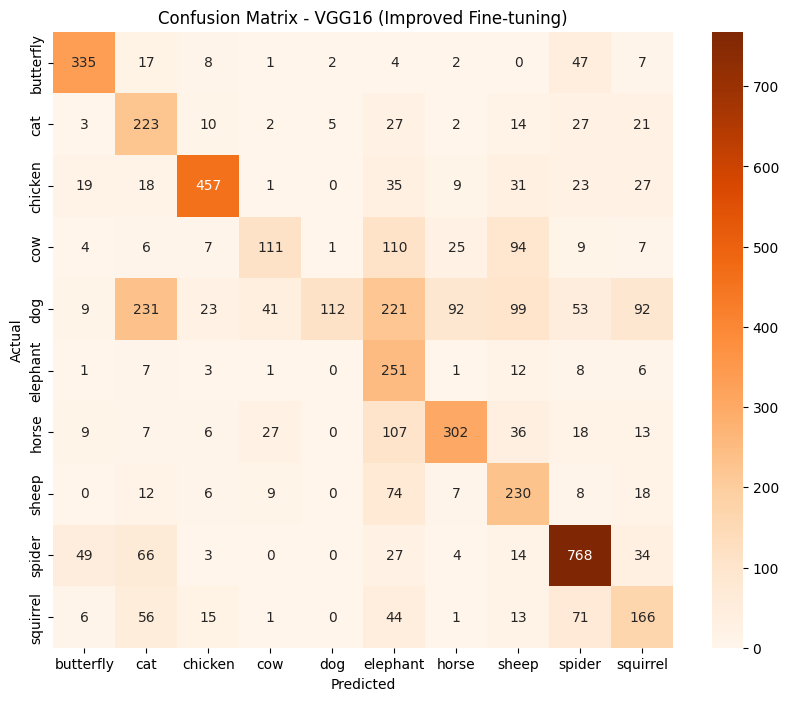

In [ ]:
# Get ground truth labels
y_true = []
y_pred = []

for i in range(len(val_generator)):
    x_batch, y_batch = val_generator[i]
    preds = model.predict(x_batch)

    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Compute metrics
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(y_true, y_pred, target_names=class_names))

cm_vgg = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_vgg, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Oranges")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - VGG16 (Improved Fine-tuning)")
plt.show()

# Conclusion for our model
After inital problems with google colab and slow image processing, we managed to fix them.
We started with a very simple CNN which already had some decent results.
After two iterations we were quite happy with our final model.
Accuracy was 0.69, f1-score between 0.6 - 0.8 mostly